In [77]:
# Import dependencies

import numpy as np
import pandas as pd

import os
import torch
import random

%load_ext autoreload
%autoreload 2

SEED = 42
torch.manual_seed(42)  # Fixes the seed for PyTorch
np.random.seed(42)  # Fixes the seed for NumPy
random.seed(42)  # Fixes the seed for Python's random module

SLIDING_WINDOW_SIZE = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# Load data
import helpers

action_folders = ["badminton", "boxing", "fencing", "golf", "reload", "shield", "snowbomb"]
tuples = []
test_tuples = []

for idx, folder in enumerate(action_folders):
    data_path = os.path.join("dataset", folder)
    for csv_file in os.listdir(data_path):
        dataframe = pd.read_csv(os.path.join(data_path, csv_file))
        if csv_file == "test.csv":
            test_tuples.append((dataframe, idx))
        else:
            tuples.append((dataframe, idx))
    
x, y = helpers.generate_data(tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE, stride=SLIDING_WINDOW_SIZE)
x_test, y_test = helpers.generate_data(test_tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE, stride = SLIDING_WINDOW_SIZE)


print("Shape of feature vector is " + str(x.shape))
print("Shape of output vector is " + str(y.shape))

Shape of feature vector is (3072, 20, 6)
Shape of output vector is (3072,)


In [79]:
# Split data
from sklearn.model_selection import train_test_split

raw_x_train, raw_x_test, y_train, y_test = x, x_test, y, y_test

# raw_x_train, raw_x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

print("Shape of raw_x_train is " + str(raw_x_train.shape))
print("Shape of y_train is " + str(y_train.shape))
print("Shape of raw_x_test is " + str(raw_x_test.shape))
print("Shape of y_test is " + str(y_test.shape))

Shape of raw_x_train is (3072, 20, 6)
Shape of y_train is (3072,)
Shape of raw_x_test is (416, 20, 6)
Shape of y_test is (416,)


In [80]:
# Extract features

x_train = helpers.convert_time_series_to_features(raw_x_train)
print("Shape of training feature vector is " + str(x_train.shape))

x_test = helpers.convert_time_series_to_features(raw_x_test)
print("Shape of testing feature vector is " + str(x_test.shape))

Shape of training feature vector is (3072, 168)
Shape of testing feature vector is (416, 168)


In [81]:
# Normalize data

from sklearn.preprocessing import StandardScaler
import pickle

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

Epoch 0 Loss 1.9397172927856445
Epoch 100 Loss 1.296859622001648
Epoch 200 Loss 1.2566496133804321
Epoch 300 Loss 1.2435497045516968
Epoch 400 Loss 1.2421505451202393
Epoch 500 Loss 1.2415975332260132
Epoch 600 Loss 1.241329312324524
Epoch 700 Loss 1.2412117719650269
Epoch 800 Loss 1.2411361932754517
Epoch 900 Loss 1.2411024570465088
Epoch 1000 Loss 1.2410751581192017
Epoch 1100 Loss 1.2410749197006226
Epoch 1200 Loss 1.2410738468170166
Epoch 1300 Loss 1.2410601377487183
Epoch 1400 Loss 1.2410460710525513
Accuracy on training set is 0.9762369791666666


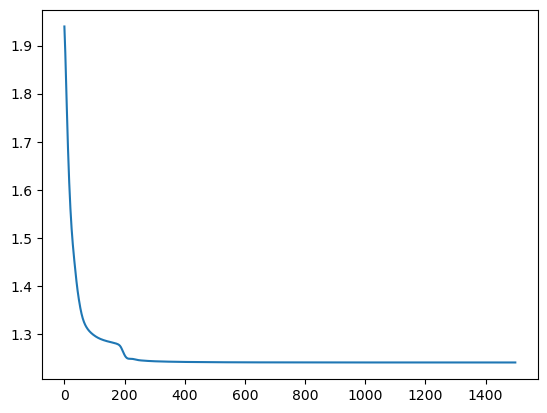

In [82]:
import torch.nn as nn

LEARNING_RATE = 0.001
EPOCHS = 1500

# Define the model
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, len(action_folders)),
    nn.Softmax(dim=1),
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(torch.tensor(x_train).float())
    loss = loss_fn(y_pred, torch.tensor(y_train).long())
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss {loss.item()}")

model.eval()
y_pred = model(torch.tensor(x_train).float())
y_pred = torch.argmax(y_pred, dim=1)

# Evaluate training accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy on training set is {accuracy}")

# Plot the loss
import matplotlib.pyplot as plt

plt.plot(losses)

[0 0 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 5 5 5 5 5 5 5 5 6 6 6]
Accuracy on testing set is 0.9206730769230769
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        59
           1       0.95      0.98      0.96        55
           2       0.86      1.00      0.93        57
           3       0.88      0.97      0.93        76
           4       1.00      0.61      0.76        61
           5       1.00      0.90      0.95        61
           6       0.92      1.00      0.96        47

    accuracy                           0.92       416
   macro avg       0.93      0.92      0.92       416
weighted avg       0.93      0.92      0.92       416



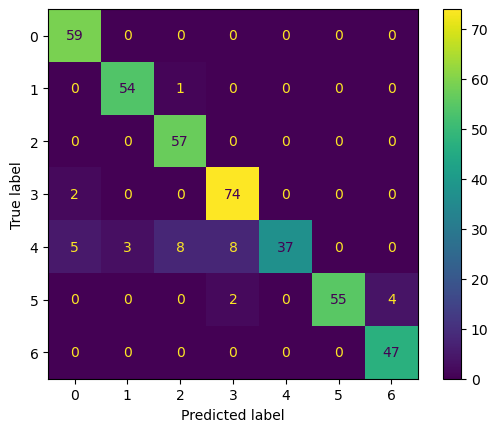

In [83]:
# Evaluate the model

model.eval()
y_pred = model(
    torch.tensor(x_test).float()
)  

# Convert matrix values to 0 if below 0.7
y_max = torch.max(y_pred, dim=1)
y_pred = torch.argmax(y_pred, dim=1)

# Get indices where y_max is less than 0.7 and see the y_test of those indices
indices = y_max.values < 0.7
print(y_test[indices])

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on testing set is {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=range(7))

display.plot()

In [84]:
# Save the weights

weights_str = ""
biases_str = ""

for param in model.named_parameters():
    isBias = False
    if "0.weight" in param[0]:
        weights_str += ("custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {")
        isBias = False
    if "0.bias" in param[0]:
        biases_str += ("custom_float input_bias[HIDDEN_LAYER_NODES] = {")
        isBias = True
    if "2.weight" in param[0]:
        weights_str += ("custom_float output_weight[HIDDEN_LAYER_NODES * OUTPUT_NODES] = {")
        isBias = False
    if "2.bias" in param[0]:
        biases_str += ("custom_float output_bias[OUTPUT_NODES] = {")
        isBias = True
        
    weight = param[1].detach().numpy().flatten().tolist()
    for w in weight:
        if isBias:
            biases_str += str(w) + ","
        else:
            weights_str += str(w) + ","
            
    if isBias:
        biases_str += "};\n\n"
    else:
        weights_str += "};\n\n"
        
print(weights_str)
print(biases_str)

custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {0.02696673385798931,0.03511796519160271,-0.0010197039227932692,-0.01630774512887001,-0.02611623890697956,0.013308684341609478,0.031438637524843216,-0.015262417495250702,-0.0027027702890336514,0.00865840818732977,-0.0019492215942591429,0.044917672872543335,0.04464966431260109,0.003061877563595772,-0.015355860814452171,-0.0067556388676166534,0.00011454866762505844,0.01489751785993576,0.018692249432206154,-0.03315063565969467,0.004358929581940174,0.0188988596200943,0.02577557973563671,0.031402889639139175,0.04307703673839569,-0.008772594854235649,0.02749541401863098,0.04065230116248131,0.02670513652265072,0.06282522529363632,0.003440225264057517,-0.025240160524845123,0.001989624695852399,0.033550020307302475,0.03728652372956276,0.042111288756132126,0.04144240543246269,0.01226785872131586,0.028947271406650543,0.0431252121925354,0.020763805136084557,0.05940835922956467,0.043184202164411545,-0.01614532060921192,0.0054999692365527

In [85]:
# Generate test cases for HLS

random.seed(SEED)

TEST_CASES = 100

test_cases = []

for i in range(TEST_CASES):
    test_case = random.choice(x_test)
    test_cases.append(test_case)

test_cases = np.array(test_cases)
single_test_case = test_cases[12]

raw_output = model(torch.tensor(test_cases).float()).detach().numpy()
pred_output = np.argmax(raw_output, axis=1)
single_pred_output = pred_output[12]

test_cases_str = "float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {"
pred_output_str = "int test_output[TEST_CASES_NUMBER] = {"

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ","
for output in pred_output:
    pred_output_str += str(output) + ","

test_cases_str += "};\n"
pred_output_str += "};\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {0.6449419818869758,-0.710636476274636,1.0406174860798905,0.9780492191954485,-1.3859905642213823,0.2496210180207714,-0.6419550597326401,-1.4164321068878978,1.4777867242388423,-0.2887116360995645,-1.950309624352056,0.7874378270023723,0.04634279840545685,-1.3814390838335249,1.4510397229584597,0.8170518241976481,-2.143124254471941,0.1665946243513339,-0.9321393958525624,-0.7333979560533944,0.19273762604577466,-1.0361626634538457,-0.6243832862852283,0.12575608959966728,-1.1810990806112311,-0.46931790218242475,0.5961126904464985,-1.3367592236058556,1.1876573392457461,-0.6549583101904571,-0.7271157654772905,0.5592824427346217,0.48680677514868803,-0.9721856436026232,-0.8966677189054251,1.5579724809673972,-0.9119883777944987,-0.07856012356694635,0.6722829456915342,-1.1444476088643791,1.5316111899712606,-0.7798784474008051,-0.9451907665194205,-0.4494646484001575,0.37022140447990914,-1.0314402809774343,1.4032277516073777,-0.7661276783111639,-0.03

In [86]:
# Generate single test case for pynq testing

TEST_CASES = 1

test_cases = []

for i in range(TEST_CASES):
    test_cases.append(single_test_case)

test_cases = np.array(test_cases)

pred_output = [ single_pred_output ]

test_cases_str = "test_input = ["
pred_output_str = "test_output = ["

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ", "
for output in pred_output:
    pred_output_str += str(output) + ", "

test_cases_str += "]\n"
pred_output_str += "]\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

test_input = [1.0483139663329355, 0.2069310872321995, 0.1580090284692205, -0.025645736164080772, 0.8439067821211077, 0.8837972619669715, 0.42593230395766946, 1.2605237856588227, -0.3922772016240924, -0.4723144296468847, 0.4248524523354999, 0.8497848807057488, 0.6087017652640896, 0.15297560113387063, -0.021298994596955816, -0.4469835293796672, 0.4279787669270893, 0.886388975352454, -0.68800743244558, 0.5333784225891346, -0.5910505342095791, -0.1949793339989792, -0.459136797092301, -0.06048657035838961, -1.3859350940212043, 0.038581090081974426, -1.2049919326829022, -0.31169624080292657, -0.4528016864874663, -0.3896976689336228, -0.4878196907535965, 0.7972804887506167, -0.7739330590195931, 0.5519532393338656, -0.5650549855648065, -0.9935685456891495, -1.3864997005233792, -0.3642872909268879, -1.0577436931489275, -0.3599840480634359, -0.2551503049111303, -0.4181266933750157, -1.037786333808558, -0.3605597402552913, -0.8549334873236011, -0.45833739830819686, -0.5127999044015898, -0.5398918

In [87]:
import time

test_input = [[




        -0.479,




        -1.2179,




        -0.4232,




        -1.8137,




        -1.6443,




        -2.4633,




        -0.25,




        -0.6336,




        -0.0521,
        1.7223,
        1.2101,
        1.5145,




        -0.37152,




        -0.9549599999999998,




        -0.27877,
        0.01579999999999997,




        -0.06824000000000001,




        -0.12147999999999995,
        0.07483608487888714,
        0.17022435313432682,
        0.10513370582263332,
        1.2428805879890474,
        0.9801326330655459,
        1.323016568906074,
        0.3789822555212843,
        0.9700128514612577,
        0.2979359142500279,
        1.2429810119225475,
        0.9825053058380907,
        1.3285820381143199,
        0.15664944178238732,
        0.14990974565663218,
        0.08891696617581848,
        0.15799999999999992,
        0.6823999999999999,
        1.138002114427595,
        3.7152000000000003,
        9.5496,
        2.7877,
        8.085318979351786,
        6.2702644806469285,
        7.936206267958993,
        14.111870000000001,
        92.70797366,
        8.337194300000002,
        77.69912348,
        51.61267835999998,
        90.85490161999998
    ]]


start = time.time()
output = model(torch.tensor(test_input).float()).detach().numpy()
output = model(torch.tensor(test_input).float()).detach().numpy()
output = model(torch.tensor(test_input).float()).detach().numpy()
output = model(torch.tensor(test_input).float()).detach().numpy()
output = model(torch.tensor(test_input).float()).detach().numpy()
end = time.time()

print("Time taken for 5 inferences is " + str((end - start)*1000) + " milliseconds")


print(output)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x48 and 168x256)